![Brain Cancer Image](https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2014/10/30/15/17/mcdc7_brain_cancer-8col.jpg)




### 🧠 Problem Definition: Brain Tumor Classification from MRI Images

**Objective:**
Build a deep learning model to classify brain MRI images into four categories:

* **Glioma tumor**
* **Meningioma tumor**
* **Pituitary tumor**
* **No tumor**

**Motivation:**
Brain tumors can be life-threatening if not diagnosed early. MRI imaging is commonly used for brain tumor detection. Automating this process using deep learning, particularly Convolutional Neural Networks (CNNs), can support faster and more accurate diagnoses, helping clinicians choose the right treatment.

**Dataset Overview:**

* Total images: **7,023**
* Classes: **Glioma, Meningioma, Pituitary, No Tumor**
* Data sources: Combination of **Figshare**, **SARTAJ**, and **Br35H** datasets
* Note: Image sizes vary and may need resizing and pre-processing before model training.

**Challenges:**

* **Data imbalance** across tumor types
* **Varying image resolutions and margins**
* **Possibly mislabeled samples** (e.g., Glioma class in the SARTAJ dataset was corrected)

**Application Areas:**

* Clinical decision support systems
* Automated diagnostic tools for radiology
* Research on tumor segmentation and localization




In [2]:
# Import essential PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Import torchvision modules for datasets, transforms, and pre-trained models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

# Import DataLoader and tools for dataset splitting
from torch.utils.data import DataLoader, random_split

# Import additional utilities
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data preparation

In [4]:
# Define data augmentation and preprocessing steps
transform_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load training dataset with applied transformations
train_dataset = ImageFolder(root='/kaggle/input/brain-tumor-mri-dataset/Training', 
                            transform=transform_pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

# Load validation dataset with the same transformations
val_dataset = ImageFolder(root='/kaggle/input/brain-tumor-mri-dataset/Testing', 
                          transform=transform_pipeline)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)


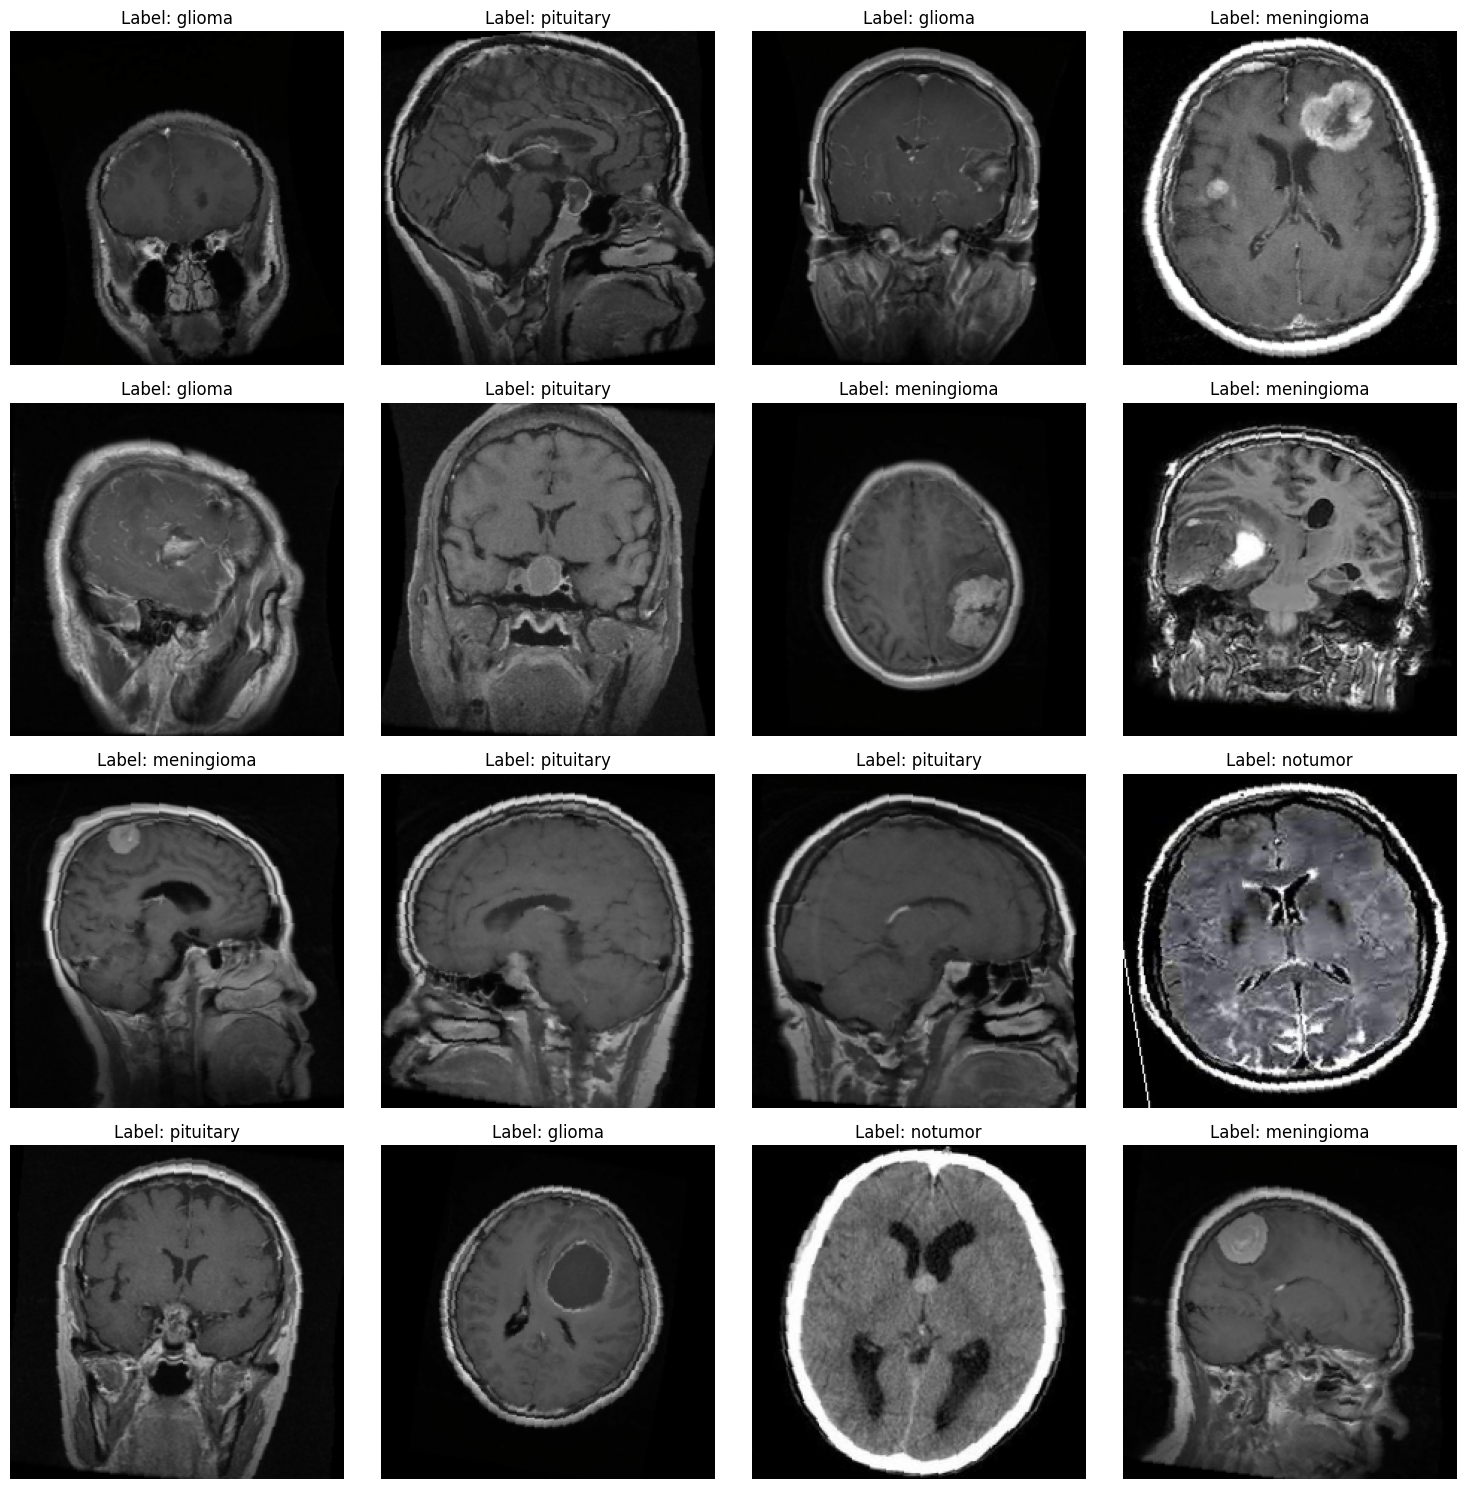

In [5]:
# Fetch a batch of samples and their corresponding labels for visualization
batch_iter = iter(train_loader)
sample_images, sample_labels = next(batch_iter)

# Convert image tensors to NumPy format and reverse normalization
mean_vals = np.array([0.485, 0.456, 0.406])
std_vals = np.array([0.229, 0.224, 0.225])
sample_images = (sample_images.numpy().transpose((0, 2, 3, 1)) * std_vals + mean_vals).clip(0, 1)

# Determine grid size and create subplots
total_images = len(sample_images)
grid_rows = int(np.ceil(total_images / 4))
fig, axes = plt.subplots(grid_rows, 4, figsize=(15, 15))

# Display each image along with its class label
for idx, ax in enumerate(axes.flat):
    if idx < total_images:
        ax.imshow(sample_images[idx])
        ax.set_title(f'Label: {train_dataset.classes[sample_labels[idx]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


### Model Building

In [6]:
class BrainTumorNet(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=32 * 56 * 56, out_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, input_tensor):
        x = self.conv_layers(input_tensor)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Instantiate the model and move it to the appropriate device
model = BrainTumorNet(num_classes=4)
model.to(device)


BrainTumorNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [7]:
num_epochs = 15
best_val_accuracy = 0.0
lr = 0.001

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)


### Training

In [9]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
        self.best_val_accuracy = 0.0
    
    def train_epoch(self):
        self.model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = correct / total
        self.train_losses.append(train_loss)
        self.train_accuracies.append(train_accuracy)
        return train_loss, train_accuracy
    
    def validate_epoch(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(self.val_loader)
        val_accuracy = correct / total
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_accuracy)
        return val_loss, val_accuracy
    
    def train(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss, train_accuracy = self.train_epoch()
            val_loss, val_accuracy = self.validate_epoch()
            
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
                  f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')
            
            if val_accuracy > self.best_val_accuracy:
                self.best_val_accuracy = val_accuracy
                torch.save(self.model, 'best_model.pth')


In [10]:
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)
trainer.train(num_epochs=num_epochs)


Epoch [1/15], Training Loss: 280.8017, Training Accuracy: 74.98%, Validation Loss: 0.5729, Validation Accuracy: 79.10%
Epoch [2/15], Training Loss: 135.1524, Training Accuracy: 85.29%, Validation Loss: 0.4131, Validation Accuracy: 83.98%
Epoch [3/15], Training Loss: 101.2171, Training Accuracy: 89.04%, Validation Loss: 0.2935, Validation Accuracy: 89.02%
Epoch [4/15], Training Loss: 74.0839, Training Accuracy: 92.77%, Validation Loss: 0.3088, Validation Accuracy: 90.01%
Epoch [5/15], Training Loss: 58.9216, Training Accuracy: 93.77%, Validation Loss: 0.1743, Validation Accuracy: 93.52%
Epoch [6/15], Training Loss: 44.3928, Training Accuracy: 95.69%, Validation Loss: 0.1901, Validation Accuracy: 93.29%
Epoch [7/15], Training Loss: 41.2064, Training Accuracy: 96.17%, Validation Loss: 0.2206, Validation Accuracy: 92.30%
Epoch [8/15], Training Loss: 32.2623, Training Accuracy: 97.04%, Validation Loss: 0.1800, Validation Accuracy: 94.89%
Epoch [9/15], Training Loss: 24.4433, Training Accura

### Evaluation

In [14]:

class Evaluation:
    def __init__(self, model, val_loader, device, train_losses, val_losses, train_accuracies, val_accuracies, classes):
        self.model = model
        self.val_loader = val_loader
        self.device = device
        self.train_losses = train_losses
        self.val_losses = val_losses
        self.train_accuracies = train_accuracies
        self.val_accuracies = val_accuracies
        self.classes = classes
    
    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct / total
        print(f'Validation Accuracy: {accuracy:.2%}')

        # Calculate metrics
        cm = confusion_matrix(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        print(f'Precision: {precision:.4f}')
        print(f'Recall:    {recall:.4f}')
        print(f'F1 Score:  {f1:.4f}')

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.classes, yticklabels=self.classes)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        # Plot training history
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(trainer.train_losses, label='Training Loss')
        plt.plot(trainer.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(trainer.train_accuracies, label='Training Accuracy')
        plt.plot(trainer.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy History')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [15]:
model = torch.load('/kaggle/working/best_model.pth', weights_only=False, map_location=device)

Validation Accuracy: 96.57%
Precision: 0.9643
Recall:    0.9640
F1 Score:  0.9637


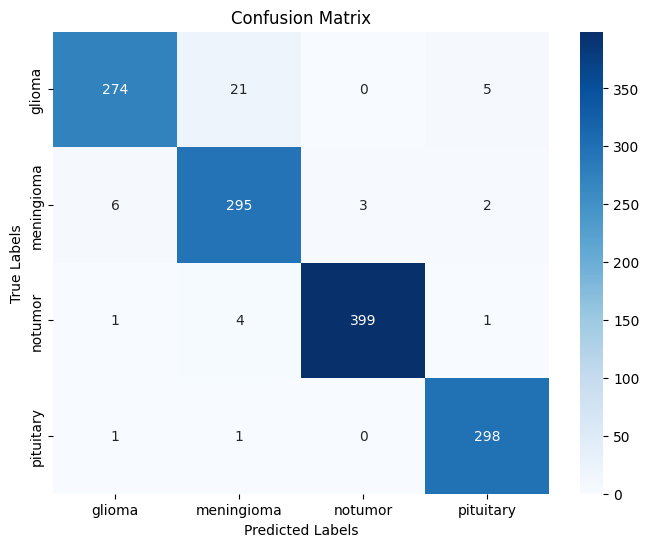

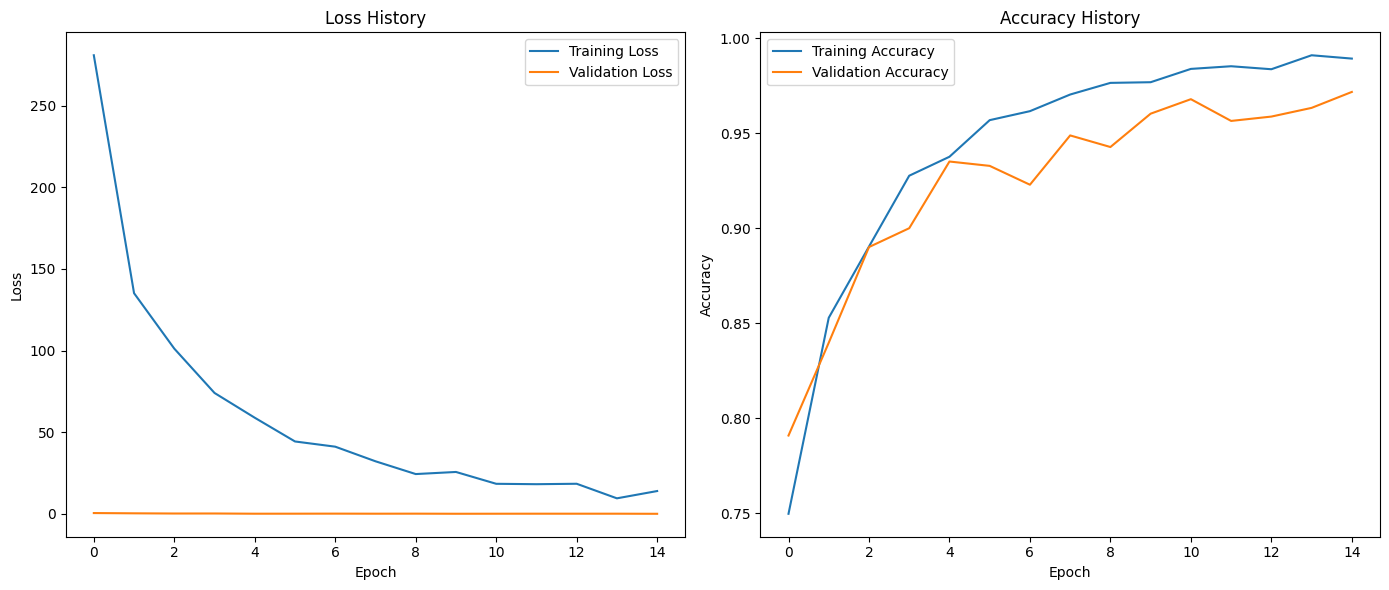

In [17]:
evaluator = Evaluation(model, val_loader, device, trainer.train_losses, trainer.val_losses, trainer.train_accuracies, trainer.val_accuracies, train_dataset.classes)
evaluator.evaluate()


we are in a pretty good spot, if we increase the training epochs to 20 or 25, we could get a better results.

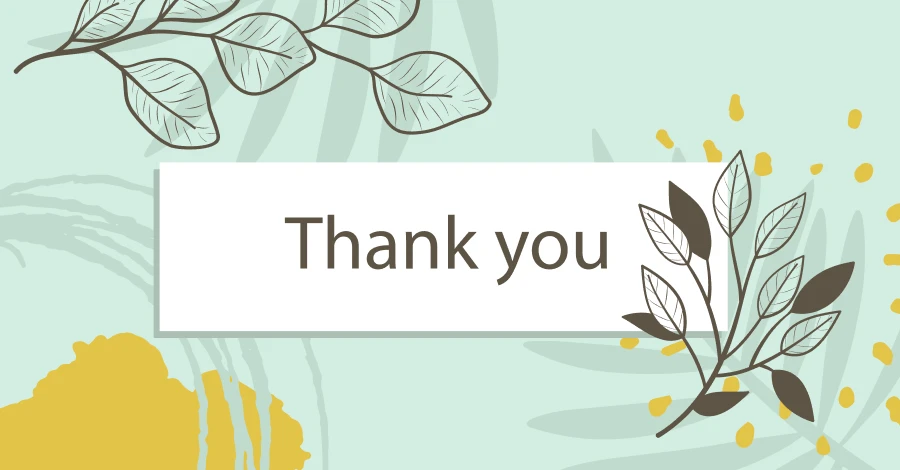
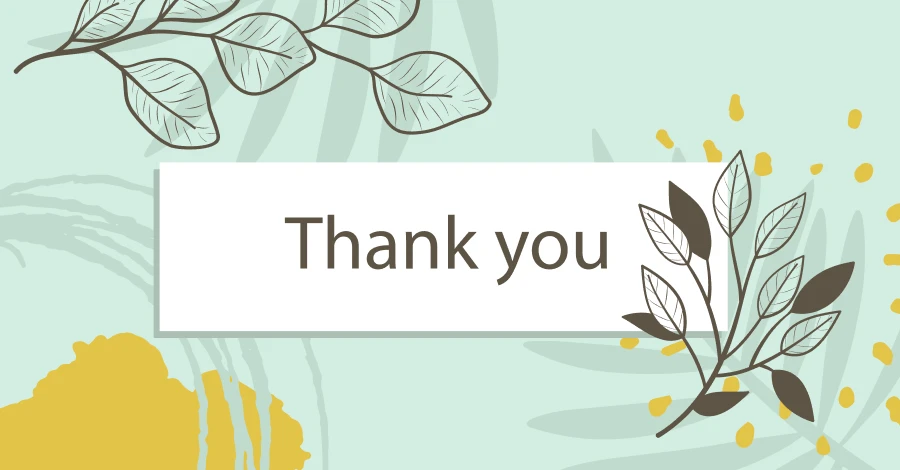